In [63]:
#!/usr/bin/env python3.9
# -*- coding: utf-8 -*-

"""
Author: Letícia Tavares
Date: 2024-08-06
Version: 1.0.0

Description:
    This script trains and evaluates a neural network model for musical genre classification. 
    It loads and preprocesses data, defines a neural network with specific hyperparameters, 
    and trains the model. The script then evaluates the model's performance through accuracy metrics, 
    learning curves, and confusion matrix. It also generates a classification report and assesses feature 
    importance using permutation importance. Results are saved and visualized through various plots.
"""

# Standard library imports
import ast  # Abstract Syntax Trees

# Third-party library imports
import numpy as np  # Numerical operations
import pandas as pd  # Data manipulation and analysis
import matplotlib.pyplot as plt  # Plotting
import random
import seaborn as sns  # Statistical data visualization
from loguru import logger  # Logging
from sklearn.model_selection import train_test_split  # Model selection and evaluation
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report  # Performance metrics
from sklearn.preprocessing import StandardScaler  # Data preprocessing
from sklearn.inspection import permutation_importance  # Model inspection
import tensorflow as tf  # Deep learning framework


# Local application/library specific imports
import functions.analysis_functions as analysis_functions  # Custom functions

import random
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

In [2]:
folder_input = "02_Output_Kfold_Models"

## Data

In [3]:
# Load data
logger.info("Loading data...")
df, all_genres, br_genres = analysis_functions.get_data(folder="")

# Load feature group model for artist
logger.info("Loading feature group model for artist...")
feats_group_model = analysis_functions.dict_feature_group()
feats_group_model_art = analysis_functions.dict_feature_group_art()

2024-08-07 17:53:00.534 | INFO     | __main__:<module>:2 - Loading data...
2024-08-07 17:53:03.993 | INFO     | __main__:<module>:6 - Loading feature group model for artist...


In [4]:
nn_result_models = pd.read_csv(f"{folder_input}/neural_network_results_F1_br_genres_more_feats.csv")
nn_result_models = nn_result_models[nn_result_models.feature_group == "combined + audio"].reset_index(drop = True)
combined_audio = [feats for k, v in feats_group_model.items() for feats in v]

params = {"dense_sizes": ast.literal_eval(nn_result_models["dense_sizes"][0]),
        "epochs": nn_result_models["epochs"][0],
        "batch_size": nn_result_models["batch_size"][0],
        "dropout_rate": nn_result_models["dropout_rate"][0]}

In [5]:
# Função para criar o modelo
def create_nn_model(dense_sizes=(32, 32), dropout_rate=0.1, input_shape=None, output_shape=None, l2_reg=None):
    inp = tf.keras.layers.Input(shape=(input_shape,))
    layer = inp

    if l2_reg != None:
        for size in dense_sizes:
            layer = tf.keras.layers.Dense(size, activation="selu", kernel_initializer="lecun_normal", 
                                        kernel_regularizer=tf.keras.regularizers.l2(l2_reg))(layer)
            layer = tf.keras.layers.Dropout(dropout_rate)(layer)

    else:
        for size in dense_sizes:
            layer = tf.keras.layers.Dense(size, activation="selu", kernel_initializer="lecun_normal")(layer)
            layer = tf.keras.layers.Dropout(dropout_rate)(layer)


    # Output layer
    out = tf.keras.layers.Dense(output_shape, activation="softmax")(layer)
    
    # Create the model
    model = tf.keras.models.Model(inputs=inp, outputs=out)
    model.compile(optimizer=tf.keras.optimizers.Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Filtrar e preparar os dados
filtered_df = df.loc[df[br_genres].sum(axis=1) == 1].reset_index(drop=True)

# Split the data into training and test sets
X = filtered_df[combined_audio].values
y = filtered_df[br_genres].values
y_encoded = np.argmax(y, axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
class_names = filtered_df[br_genres].columns.tolist()

# # Criar o dataset
# train_dataset = tf.data.Dataset.from_tensor_slices((X_train_scaled, y_train))
# train_dataset = train_dataset.shuffle(buffer_size=len(X_train_scaled), seed=42)
# train_dataset = train_dataset.batch(params["batch_size"])

## Experiment I

In [6]:
# Inicialize o modelo
model = create_nn_model(
    dense_sizes=params["dense_sizes"],
    dropout_rate=params["dropout_rate"],
    input_shape=X.shape[1],  # Substitua pelo tamanho real do input
    output_shape=y.shape[1],  # Número de classes
)

# Treine o modelo e salve o histórico
history = model.fit(
    X_train_scaled,
    y_train,
    epochs=50,
    batch_size=params["batch_size"],  # Ajuste o batch_size conforme necessário
    validation_data=(X_test_scaled, y_test)
)


Epoch 1/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4894 - loss: 1.3510 - val_accuracy: 0.6179 - val_loss: 0.9910
Epoch 2/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 882us/step - accuracy: 0.6061 - loss: 1.0167 - val_accuracy: 0.6306 - val_loss: 0.9649
Epoch 3/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 888us/step - accuracy: 0.6223 - loss: 0.9947 - val_accuracy: 0.6406 - val_loss: 0.9476
Epoch 4/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 858us/step - accuracy: 0.6301 - loss: 0.9720 - val_accuracy: 0.6453 - val_loss: 0.9417
Epoch 5/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 821us/step - accuracy: 0.6411 - loss: 0.9494 - val_accuracy: 0.6483 - val_loss: 0.9341
Epoch 6/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 808us/step - accuracy: 0.6471 - loss: 0.9312 - val_accuracy: 0.6476 - val_loss: 0.9287
Epoch 7/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 811us/step - accuracy: 0.6491 - loss: 0.9217 - val_accuracy: 0.6553 - val_loss: 0.9200
Epoch 8/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step - accuracy: 0.6532 - loss: 0.9085 - va

Acurácia no conjunto de treinamento: 0.7850
Acurácia no conjunto de teste: 0.6804


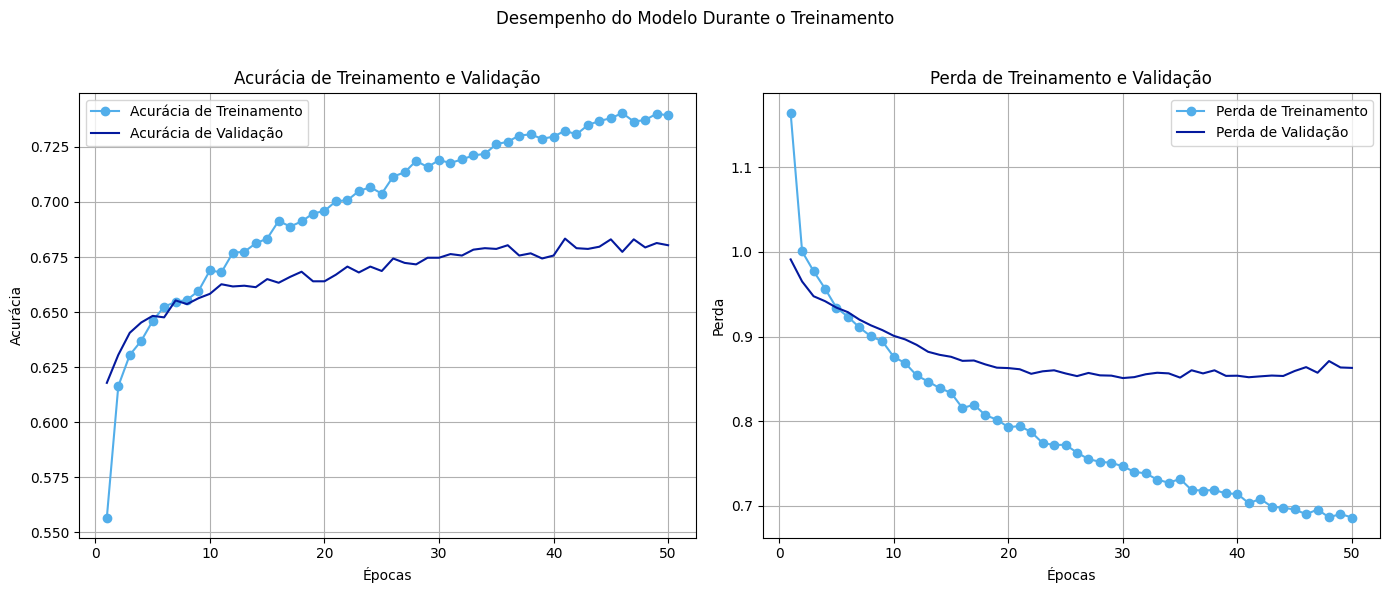

In [7]:
# Avaliar o modelo no conjunto de treinamento
train_loss, train_accuracy = model.evaluate(X_train_scaled, y_train, verbose=0)
print(f'Acurácia no conjunto de treinamento: {train_accuracy:.4f}')

# Avaliar o modelo no conjunto de teste
test_loss, test_accuracy = model.evaluate(X_test_scaled, y_test, verbose=0)
print(f'Acurácia no conjunto de teste: {test_accuracy:.4f}')

# Extraindo os dados de acurácia e perda do histórico
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Definindo o número de épocas
epochs = range(1, len(train_acc) + 1)

# Criar a figura e os eixos
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plotar a acurácia
ax1.plot(epochs, train_acc, color='#52aeea', marker='o', label='Acurácia de Treinamento')
ax1.plot(epochs, val_acc, color = '#04199d', label='Acurácia de Validação')
ax1.set_title('Acurácia de Treinamento e Validação')
ax1.set_xlabel('Épocas')
ax1.set_ylabel('Acurácia')
ax1.legend()
ax1.grid(True)

# Plotar a perda
ax2.plot(epochs, train_loss, color='#52aeea', marker='o',label='Perda de Treinamento')
ax2.plot(epochs, val_loss, color = '#04199d', label='Perda de Validação')
ax2.set_title('Perda de Treinamento e Validação')
ax2.set_xlabel('Épocas')
ax2.set_ylabel('Perda')
ax2.legend()
ax2.grid(True)

# Título geral da figura
fig.suptitle('Desempenho do Modelo Durante o Treinamento')

# Ajustar layout e exibir os gráficos
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Ajustar o layout para o título geral
plt.show()

Acurácia no conjunto de treinamento: 0.7850
Acurácia no conjunto de teste: 0.6804

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step


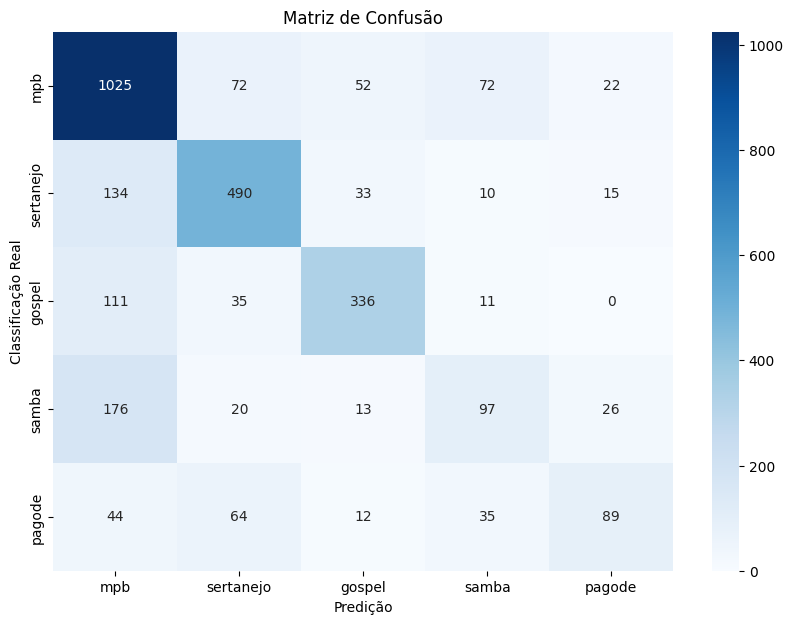

In [8]:
y_test_pred_prob = model.predict(X_test_scaled)  # Retorna probabilidades
y_test_pred = np.argmax(y_test_pred_prob, axis=1)  # Converte probabilidades em rótulos de classe

# Calcular a matriz de confusão
cm = confusion_matrix(y_test, y_test_pred)

# Visualizar a matriz de confusão com um heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predição')
plt.ylabel('Classificação Real')
plt.title('Matriz de Confusão')
plt.show()

## Experiment II

In [9]:
# Parâmetros do modelo
params = {
    "dense_sizes": (64, 64),
    "dropout_rate": 0.5,
    "batch_size": 32,
    "l2_reg": 0.01
}

# Inicializar e treinar o modelo
model = create_nn_model(
    dense_sizes=params["dense_sizes"],
    dropout_rate=params["dropout_rate"],
    input_shape=X.shape[1],
    output_shape=len(class_names),  # Número de classes
    l2_reg=params["l2_reg"]
)

history = model.fit(
    X_train_scaled,
    y_train,
    epochs=50,
    batch_size=params["batch_size"],
    validation_data=(X_test_scaled, y_test),
)

# Extraindo os dados de acurácia e perda do histórico
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Definindo o número de épocas
epochs = range(1, len(train_acc) + 1)


Epoch 1/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3262 - loss: 3.2180 - val_accuracy: 0.6009 - val_loss: 1.7844
Epoch 2/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 807us/step - accuracy: 0.5321 - loss: 1.8723 - val_accuracy: 0.6182 - val_loss: 1.4397
Epoch 3/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 810us/step - accuracy: 0.5808 - loss: 1.4792 - val_accuracy: 0.6229 - val_loss: 1.2506
Epoch 4/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 809us/step - accuracy: 0.6023 - loss: 1.2833 - val_accuracy: 0.6256 - val_loss: 1.1491
Epoch 5/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 817us/step - accuracy: 0.6101 - loss: 1.1822 - val_accuracy: 0.6232 - val_loss: 1.0970
Epoch 6/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 830us/step - accuracy: 0.6148 - loss: 1.1271 - val_accuracy: 0.6269 - val_loss: 1.0718
Epoch 7/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 822us/step - accuracy: 0.6122 - loss: 1.1087 - val_accuracy: 0.6289 - val_loss: 1.0584
Epoch 8/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 820us/step - accuracy: 0.6189 - loss: 1.0915 - va

Acurácia no conjunto de Treinamento: 0.6452
Acurácia no conjunto de Validação: 0.6259


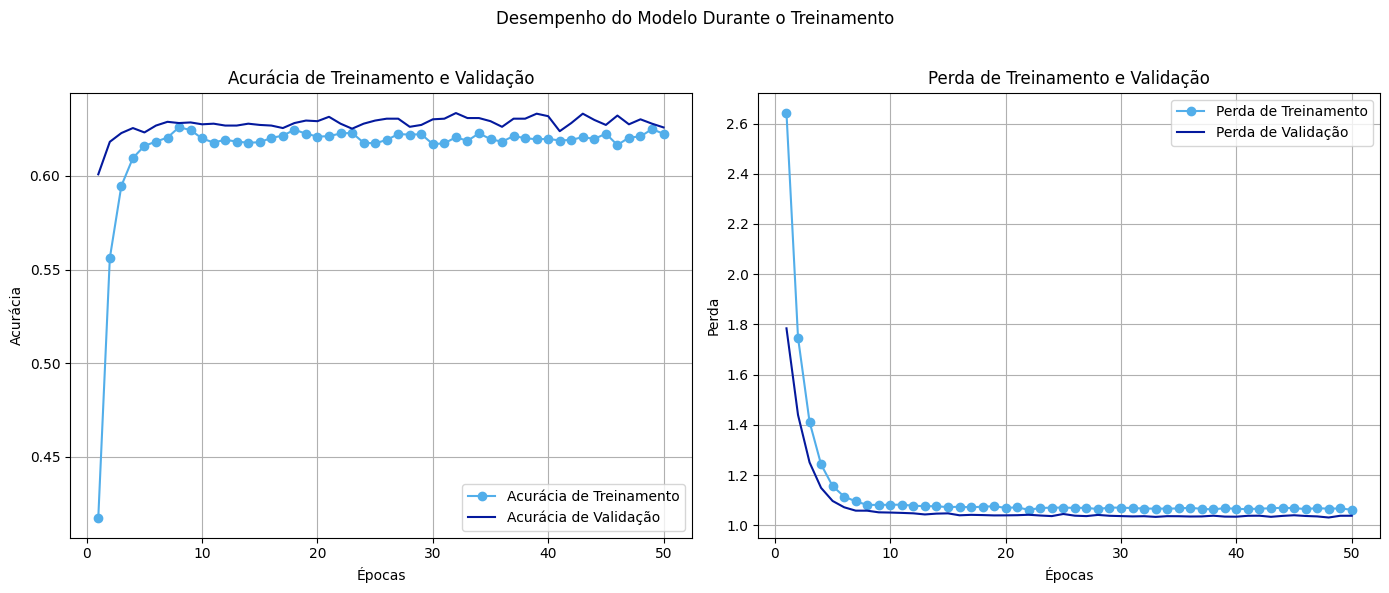

In [10]:
# Avaliar o modelo no conjunto de treinamento
train_loss, train_accuracy = model.evaluate(X_train_scaled, y_train, verbose=0)
print(f'Acurácia no conjunto de Treinamento: {train_accuracy:.4f}')

# Avaliar o modelo no conjunto de teste
test_loss, test_accuracy = model.evaluate(X_test_scaled, y_test, verbose=0)
print(f'Acurácia no conjunto de Validação: {test_accuracy:.4f}')

# Extraindo os dados de acurácia e perda do histórico
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plotar a acurácia
ax1.plot(epochs, train_acc, color='#52aeea', marker='o', label='Acurácia de Treinamento')
ax1.plot(epochs, val_acc, color = '#04199d', label='Acurácia de Validação')
ax1.set_title('Acurácia de Treinamento e Validação')
ax1.set_xlabel('Épocas')
ax1.set_ylabel('Acurácia')
ax1.legend()
ax1.grid(True)

# Plotar a perda
ax2.plot(epochs, train_loss, color='#52aeea', marker='o', label='Perda de Treinamento')
ax2.plot(epochs, val_loss, color = '#04199d', label='Perda de Validação')
ax2.set_title('Perda de Treinamento e Validação')
ax2.set_xlabel('Épocas')
ax2.set_ylabel('Perda')
ax2.legend()
ax2.grid(True)

# Título geral da figura
fig.suptitle('Desempenho do Modelo Durante o Treinamento')

# Ajustar layout e exibir os gráficos
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Ajustar o layout para o título geral
plt.show()

### Correlation Matrix

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 823us/step


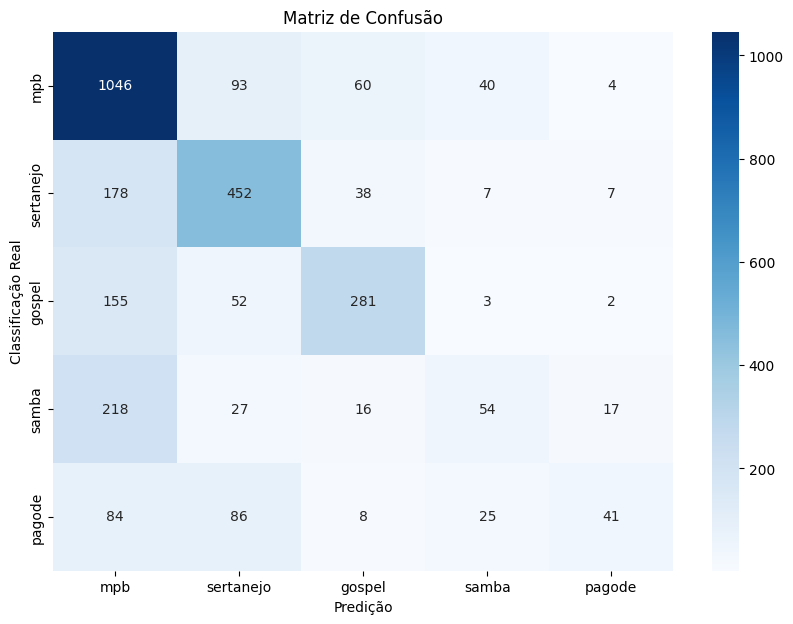

In [12]:
y_test_pred_prob = model.predict(X_test_scaled)  # Retorna probabilidades
y_test_pred = np.argmax(y_test_pred_prob, axis=1)  # Converte probabilidades em rótulos de classe

# Calcular a matriz de confusão
cm = confusion_matrix(y_test, y_test_pred)

# Visualizar a matriz de confusão com um heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predição')
plt.ylabel('Classificação Real')
plt.title('Matriz de Confusão')
plt.show()

### Report

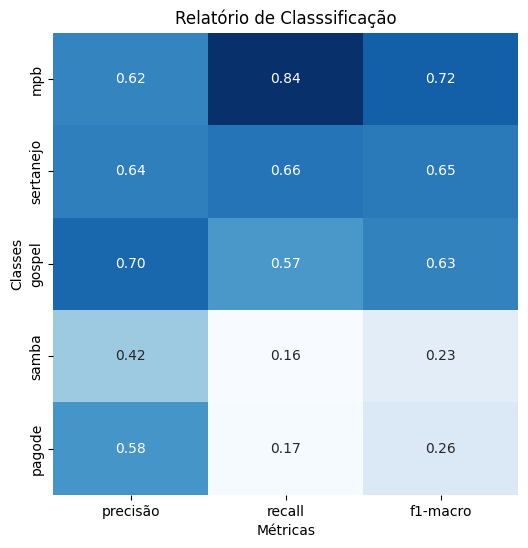

In [24]:
# Gerar o relatório de classificação
report_dict = classification_report(y_test, y_test_pred, target_names=class_names, output_dict=True)
df_report = pd.DataFrame(report_dict).transpose()

# df_report.set_index(df_report.columns[0], inplace=True)
df_report = df_report.rename({'precision':'precisão', 'f1-score':'f1-macro'}, axis=1)

# Plotar o DataFrame usando seaborn
plt.figure(figsize=(6, 6))
sns.heatmap(df_report.iloc[:-3, :-1], annot=True, cmap="Blues", cbar=False, fmt=".2f")
plt.title('Relatório de Classsificação')
plt.xlabel('Métricas')
plt.ylabel('Classes')
plt.show()

### Importance

 Importância das 20 principais características do modelo, determinada por permutação. 
 As barras verticais representam a importância média de cada característica para a previsão, 
 enquanto as barras de erro (se incluídas) indicam a variabilidade da importância estimada. 

In [33]:
def model_accuracy(Model, X, y):
    y_pred = model.predict(X)
    y_pred_classes = np.argmax(y_pred, axis=1)
    return accuracy_score(y, y_pred_classes)

# Calcular a importância por permutação
result = permutation_importance(
    estimator=model,       # Modelo Keras
    X=X_test_scaled,       # Dados de teste
    y=y_test,              # Rótulos verdadeiros
    scoring=model_accuracy,  # Função de métrica personalizada
    n_repeats=10,          # Número de repetições para a permutação
    random_state=42        # Definir uma semente para reprodutibilidade
)

# Obtenha a média e o desvio padrão das importâncias
importances = result.importances_mean
std = result.importances_std

# Ordene as características por importância
indices = np.argsort(importances)[::-1]

for idx in indices:
    print(f'{X.columns[idx]}: {importances[idx]}')

# Plotar a importância das características
plt.figure()
plt.title("Importância das Características por Permutação")
plt.bar(range(X_test.shape[1]), importances[indices], yerr=std[indices], align="center")
plt.xticks(range(X_test.shape[1]), X.columns[indices], rotation=90)
plt.xlim([-1, X_test.shape[1]])
plt.show()

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 947us/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 937us/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 933us/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 950us/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 

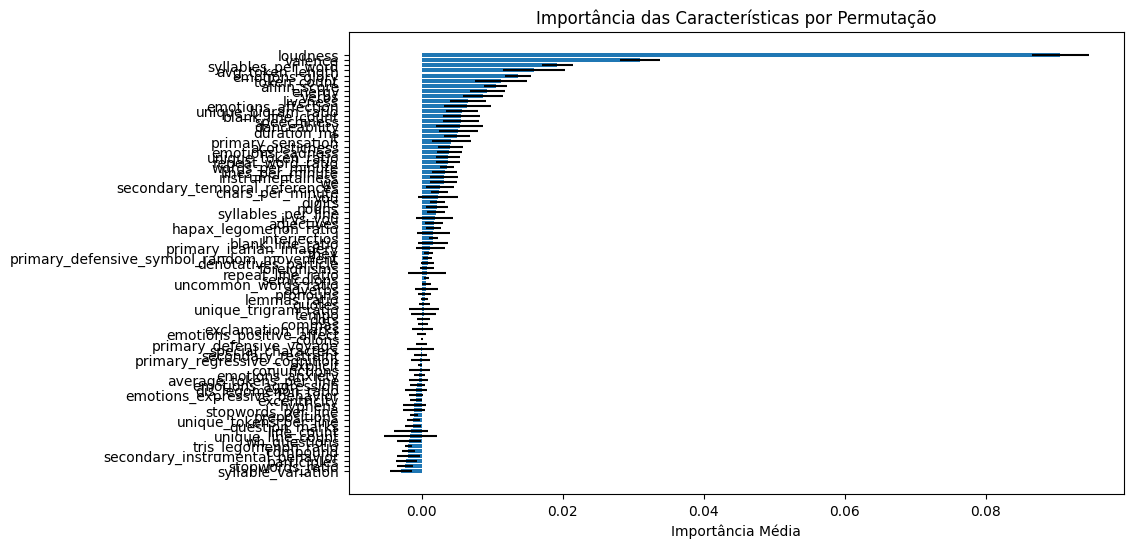

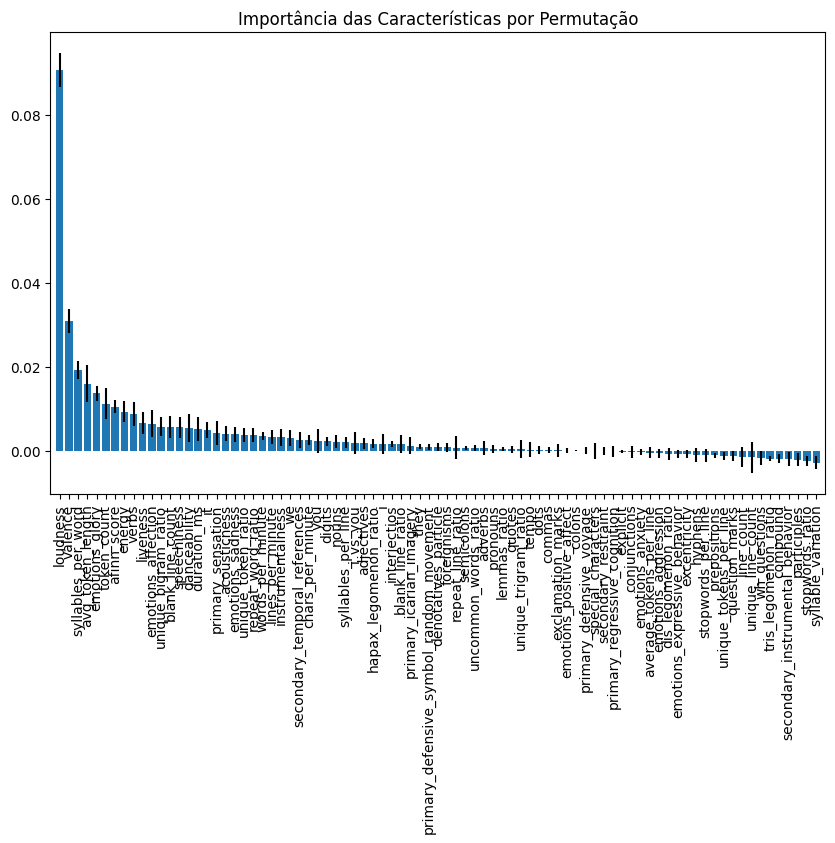

In [49]:

# Plotar a importância das características
features = filtered_df[combined_audio].columns
sorted_idx = importances.argsort()


plt.figure(figsize=(10, 6))
plt.barh(range(X_test_scaled.shape[1]), importances[sorted_idx], xerr=importances_std[sorted_idx], align='center')
plt.yticks(range(X_test_scaled.shape[1]), [features[i] for i in sorted_idx])
plt.xlabel('Importância Média')
plt.title('Importância das Características por Permutação')
plt.show()

sorted_idx = importances.argsort()[::-1]


plt.figure(figsize=(10, 6))
plt.title("Importância das Características por Permutação")
plt.bar(range(X_test_scaled.shape[1]), importances[sorted_idx], yerr=importances_std[sorted_idx], align="center")
plt.xticks(range(X_test_scaled.shape[1]), [features[i] for i in sorted_idx], rotation=90)
plt.xlim([-1, X_test.shape[1]])
plt.show()

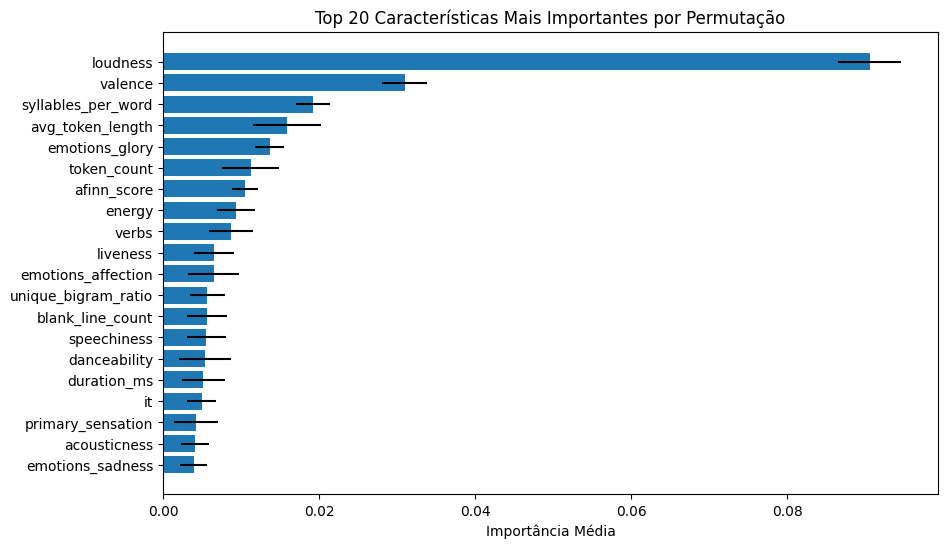

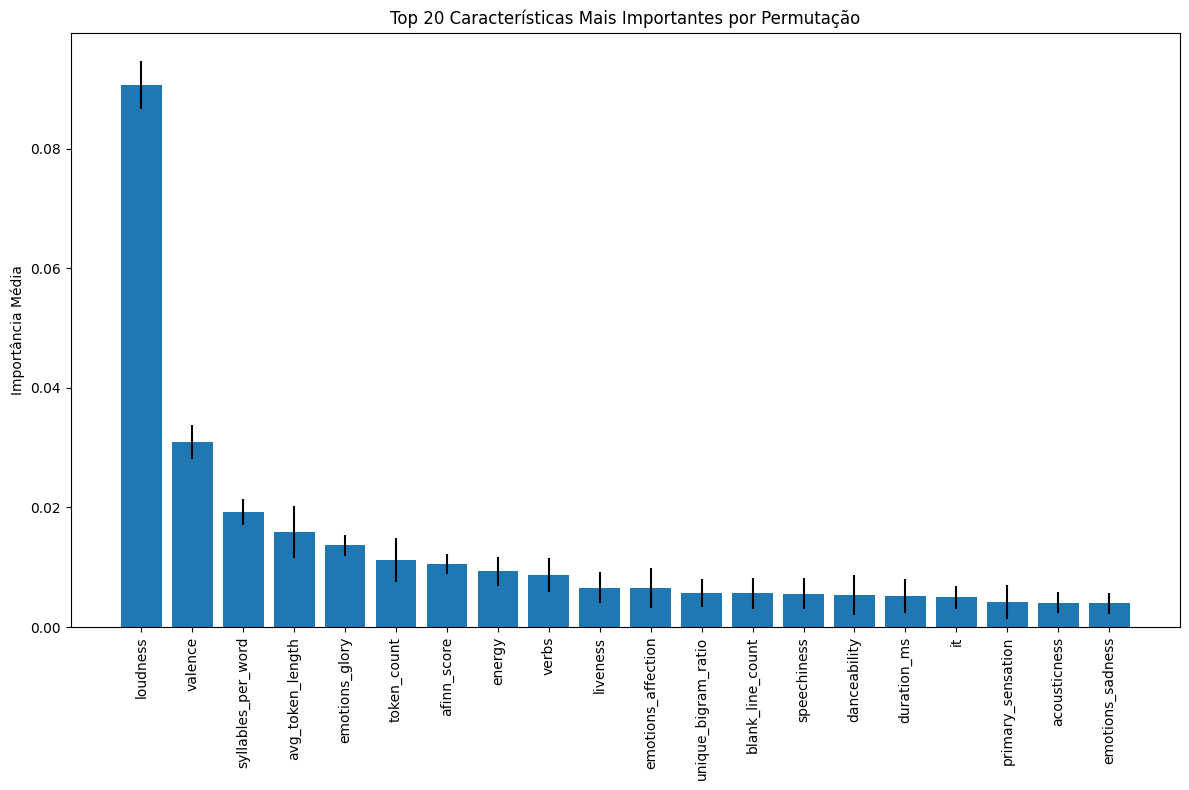

In [62]:



import matplotlib.pyplot as plt

n_feats = 20

# Nomes das características
feature_names = filtered_df[combined_audio].columns

# Ordenar as características pela importância
sorted_idx = importances.argsort()
# Selecionar as 20 características mais importantes
top_n_idx = sorted_idx[-n_feats:]
top_n_importances = importances[top_n_idx]
top_n_importances_std = importances_std[top_n_idx]
top_n_feature_names = [feature_names[i] for i in top_n_idx]


# Plotar a importância das 20 características mais importantes
plt.figure(figsize=(10, 6))
plt.barh(range(n_feats), top_n_importances, xerr=top_n_importances_std, align='center')
plt.yticks(range(n_feats), top_n_feature_names)
plt.xlabel('Importância Média')
plt.title('Top 20 Características Mais Importantes por Permutação')
plt.show()

# Ordenar as características pela importância (em ordem decrescente)
sorted_idx = importances.argsort()[::-1]  # Reverte a ordem para decrescente

# Selecionar as 20 características mais importantes
top_n_idx = sorted_idx[:n_feats]  # Seleciona as mais importantes
top_n_importances = importances[top_n_idx]
top_n_importances_std = importances_std[top_n_idx]
top_n_feature_names = [feature_names[i] for i in top_n_idx]

# Plotar a importância das 20 características mais importantes (barras verticais)
plt.figure(figsize=(12, 8))
plt.bar(range(n_feats), top_n_importances, yerr=top_n_importances_std, align='center')
plt.xticks(range(n_feats), top_n_feature_names, rotation=90)
plt.ylabel('Importância Média')
plt.title('Top 20 Características Mais Importantes por Permutação')
plt.tight_layout()  # Ajusta o layout para evitar sobreposição de texto
plt.show()
